In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import (TimeSeriesSplit, train_test_split, 
                                     cross_val_score)
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
import pickle

In [2]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    print(df)
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
        'dayofyear','dayofmonth','weekofyear', 'LocationIdCode', 'MealTypeCode', 'MenuItemCode']]
    
    print(X)
    if label:
        y = df[label]
        return X, y
    return X

In [3]:
df = pd.read_csv('RegressorDataset.csv', index_col=[0], parse_dates=[0])

#replace categorical columns with text with categorical column with numerical values
df.LocationId = pd.Categorical(df.LocationId)
df['LocationIdCode'] = df.LocationId.cat.codes
del df['LocationId']

df.MealType = pd.Categorical(df.MealType)
df['MealTypeCode'] = df.MealType.cat.codes
del df['MealType']

df.MenuItem = pd.Categorical(df.MenuItem)
df['MenuItemCode'] = df.MenuItem.cat.codes
del df['MenuItem']

#splitting master
split_date = '01-Aug-2020'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

#train and test for master
X_train, y_train = create_features(df_train, label='LineLength')
X_test, y_test = create_features(df_test, label='LineLength')

#add datasets for distinct dining courts
#earhart: 0 ford: 1 hillenbrand: 2 Wiley: 3 Windsor: 4

#df_earhart = df.loc[df['LocationIdCode'] == 0]
#df_ford = df.loc[df['LocationIdCode'] == 1]
#df_hillenbrand = df.loc[df['LocationIdCode'] == 2]
#df_wiley = df.loc[df['LocationIdCode'] == 3]
#df_windsor = df.loc[df['LocationIdCode'] == 4]

                     LineLength  LocationIdCode  MealTypeCode  MenuItemCode
Datetime                                                                   
2018-08-28 12:21:00         150               1             0          2453
2018-08-28 12:21:00         150               1             0          2459
2018-08-28 12:21:00         150               1             0          2779
2018-08-28 12:21:00         150               1             0          1981
2018-08-28 12:21:00         150               1             0          1977
...                         ...             ...           ...           ...
2017-11-02 17:58:00         200               2             1          2930
2017-11-02 17:58:00         200               2             1          2487
2017-11-02 17:58:00         200               2             1           711
2017-11-02 17:58:00         200               2             1          1567
2017-11-02 17:58:00         200               2             1          2246

[178095 row

<ipython-input-2-0d987608ff4c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-2-0d987608ff4c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [4]:
#model for master
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [5]:
df_test['LineLengthPrediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

In [6]:
#calibrate predition values
df_all.LineLengthPrediction = df_all.LineLengthPrediction * 1.25

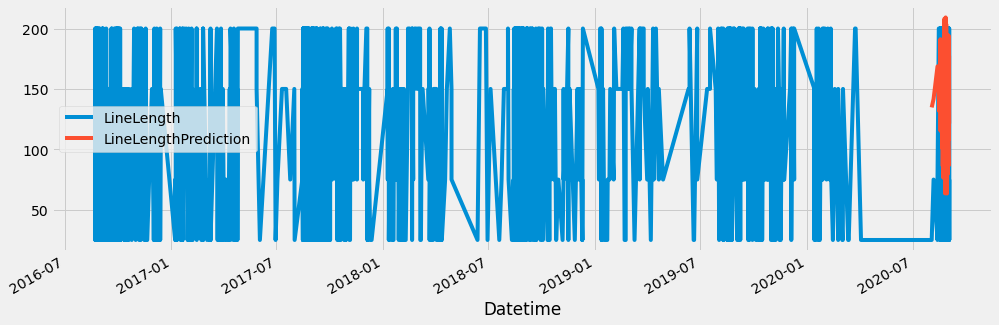

In [8]:
_ = df_all[['LineLength','LineLengthPrediction']].plot(figsize=(15, 5))

In [9]:
# run XGBoost algorithm with hyperparameters optimization
# this model outperforms the linear regression
from functools import partial

def train_xgb(params, X_train, y_train):
    """
    Train XGBoost regressor using the parameters given as input. The model
    is validated using standard cross validation technique adapted for time series
    data. This function returns a friendly output for the hyperopt parameter optimization
    module.
    
    Parameters
    ----------
    params: dict with the parameters of the XGBoost regressor. For complete list see: 
            https://xgboost.readthedocs.io/en/latest/parameter.html
    X_train: pd.DataFrame with the training set features
    y_train: pd.Series with the training set targets    
    
    Returns
    -------
    dict with keys 'model' for the trained model, 'status' containing the hyperopt
    status string and 'loss' with the RMSE obtained from cross-validation
    """
    
    n_estimators = int(params["n_estimators"])
    max_depth= int(params["max_depth"])

    try:
        model = xgb.XGBRegressor(n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 learning_rate=params["learning_rate"],
                                 subsample=params["subsample"])

        result = model.fit(X_train, 
                           y_train.values.ravel(),
                           eval_set=[(X_train, y_train.values.ravel())],
                           early_stopping_rounds=50,
                           verbose=False)
        
        # cross validate using the right iterator for time series
        cv_space = TimeSeriesSplit(n_splits=5)
        cv_score = cross_val_score(model, 
                                   X_train, y_train.values.ravel(), 
                                   cv=cv_space, 
                                   scoring=mape_scorer)

        rmse = np.abs(np.mean(np.array(cv_score)))
        
        #serialize the model
        pickle.dump(model, open("pima.pickle.dat", "wb"))
        
        return {
            "loss": rmse,
            "status": STATUS_OK,
            "model": model
        }
        
    except ValueError as ex:
        return {
            "error": ex,
            "status": STATUS_FAIL
        }



In [9]:
from sklearn.metrics import make_scorer

# MAPE computation
def mape(y, yhat, perc=True):
    n = len(yhat.index) if type(yhat) == pd.Series else len(yhat)    
    mape = []
    for a, f in zip(y, yhat):
        # avoid division by 0
        if f > 1e-9:
            mape.append(np.abs((a - f)/a))
    mape = np.mean(np.array(mape))
    return mape * 100. if perc else mape

mape_scorer = make_scorer(mape, greater_is_better=False)

In [11]:
#run this only when doing hyperparameter optimization, as it will take 20 mins to run.
def optimize_xgb(X_train, y_train, max_evals=10):
    """
    Run Bayesan optimization to find the optimal XGBoost algorithm
    hyperparameters.
    
    Parameters
    ----------
    X_train: pd.DataFrame with the training set features
    y_train: pd.Series with the training set targets
    max_evals: the maximum number of iterations in the Bayesian optimization method
    
    Returns
    -------
    best: dict with the best parameters obtained
    trials: a list of hyperopt Trials objects with the history of the optimization
    """
    
    space = {
        "n_estimators": hp.quniform("n_estimators", 100, 1000, 10),
        "max_depth": hp.quniform("max_depth", 1, 8, 1),
        "learning_rate": hp.loguniform("learning_rate", -5, 1),
        "subsample": hp.uniform("subsample", 0.8, 1),
        "gamma": hp.quniform("gamma", 0, 100, 1)
    }

    objective_fn = partial(train_xgb, 
                           X_train=X_train, 
                           y_train=y_train)
    
    trials = Trials()
    best = fmin(fn=objective_fn,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    # evaluate the best model on the test set
    print(f"""
    Best parameters:
        learning_rate: {best["learning_rate"]} 
        n_estimators: {best["n_estimators"]}
        max_depth: {best["max_depth"]}
        sub_sample: {best["subsample"]}
        gamma: {best["gamma"]}
    """)
    return best, trials

best, trials = optimize_xgb(X_train, y_train, max_evals=10)

100%|██████████| 10/10 [23:19<00:00, 139.92s/trial, best loss: 113.60821897268347]

    Best parameters:
        learning_rate: 0.22716759978149673 
        n_estimators: 880.0
        max_depth: 6.0
        sub_sample: 0.8446564764594414
        gamma: 83.0
    


In [12]:
loaded_model = pickle.load(open("pima.pickle.dat", "rb"))

In [13]:
loaded_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.6693612107968173, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=790, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.9108137735772796, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [73]:

# evaluate the best model on the test set. this takes 15 seconds.
res = train_xgb(best, X_test, y_test)
xgb_model = res["model"]
predictions = xgb_model.predict(X_test)
cv_score = min([f["loss"] for f in trials.results if f["status"] == STATUS_OK])
test_score = mape(y_test.values, predictions)

print(f"Root mean square error cross-validation/test: {cv_score:.4f} / {test_score:.4f}")

Root mean square error cross-validation/test: 113.6082 / 22.9916


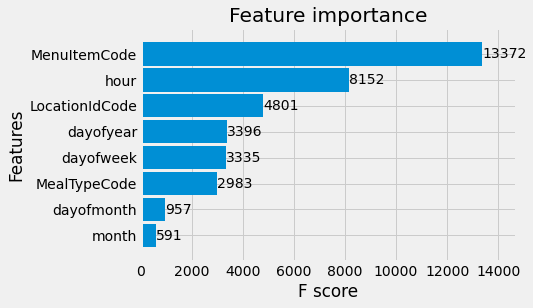

In [74]:
_ = plot_importance(xgb_model, height=0.9)

In [75]:
df_test['LineLengthPrediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

In [76]:
#split prediction dataset by dining court
df_earhart = df_all.loc[df_all['LocationIdCode'] == 0]
df_ford = df_all.loc[df_all['LocationIdCode'] == 1]
df_hillenbrand = df_all.loc[df_all['LocationIdCode'] == 2]
df_wiley = df_all.loc[df_all['LocationIdCode'] == 3]
df_windsor = df_all.loc[df_all['LocationIdCode'] == 4]

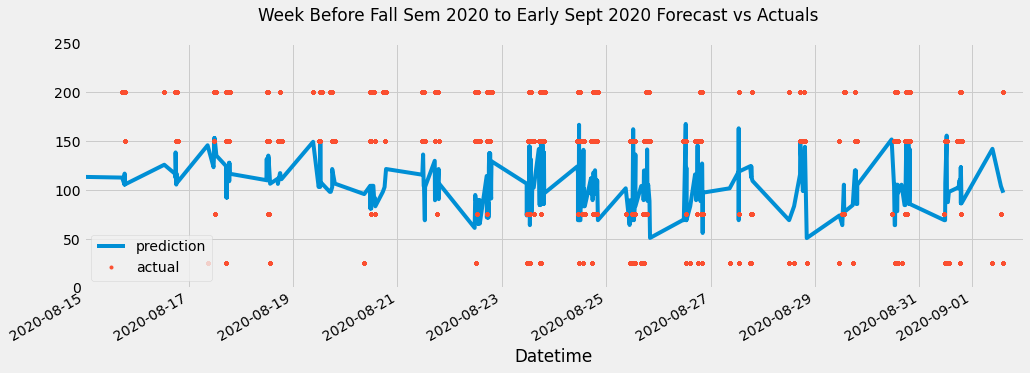

In [24]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-15-2020', upper='09-02-2020')
ax.legend(['prediction', 'actual'])
plot = plt.suptitle('Week Before Fall Sem 2020 to Early Sept 2020 Forecast vs Actuals')

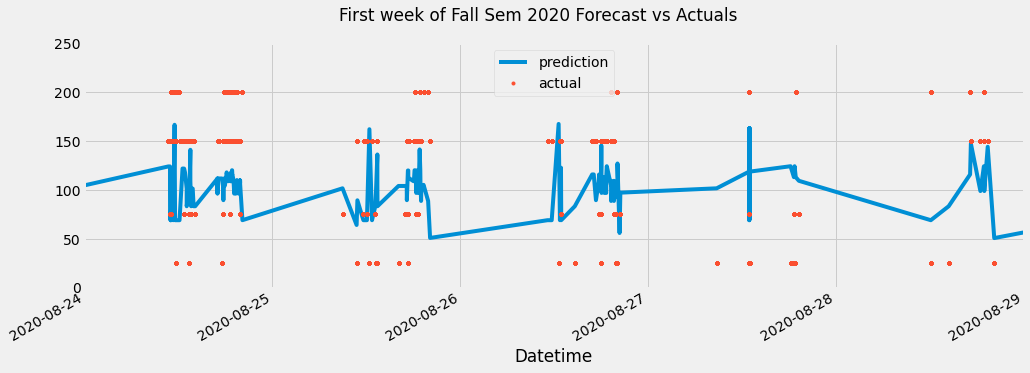

In [25]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-24-2020', upper='08-29-2020')
ax.legend(['prediction', 'actual'])
plot = plt.suptitle('First week of Fall Sem 2020 Forecast vs Actuals')

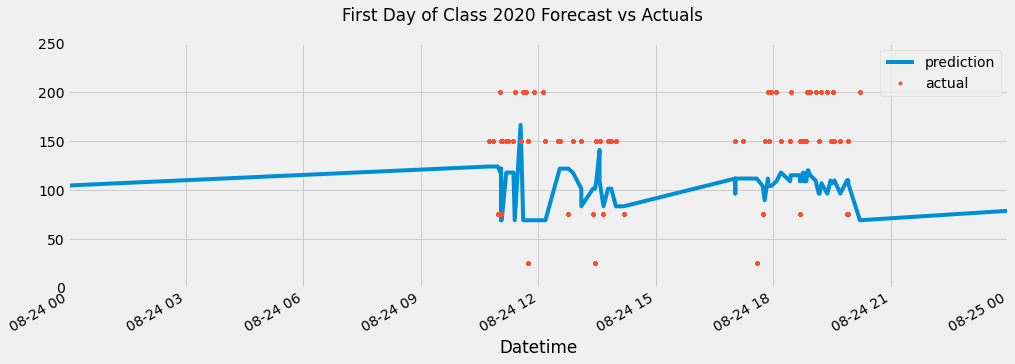

In [26]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-24-2020', upper='08-25-2020')
ax.legend(['prediction', 'actual'])
plot = plt.suptitle('First Day of Class 2020 Forecast vs Actuals')

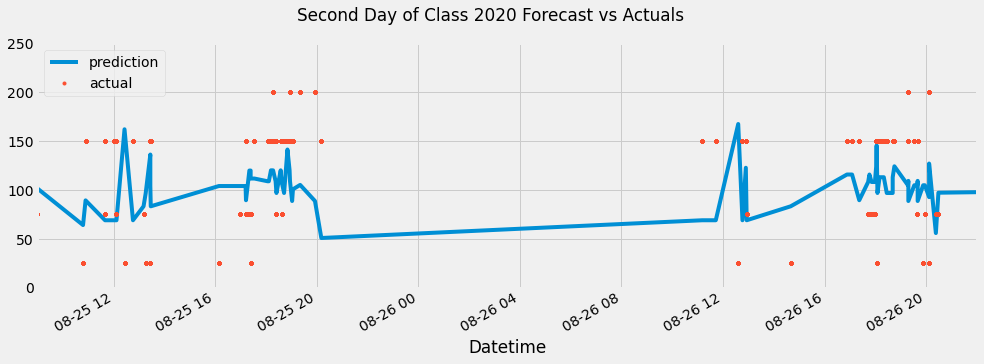

In [27]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-25-2020 09', upper='08-26-2020 22')
ax.legend(['prediction', 'actual'])
plot = plt.suptitle('Second Day of Class 2020 Forecast vs Actuals')

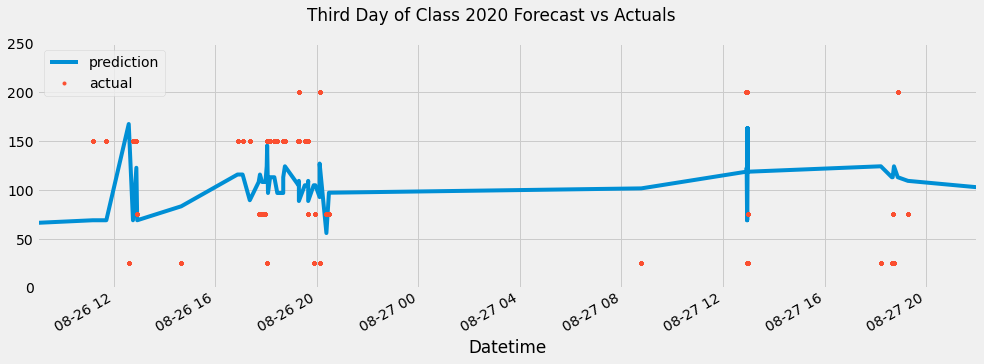

In [28]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-26-2020 09', upper='08-27-2020 22')
ax.legend(['prediction', 'actual'])
plot = plt.suptitle('Third Day of Class 2020 Forecast vs Actuals')

In [ ]:
#visualizing preditions/actual for a dining court
_ = df_all_wiley[['LineLength','LineLengthPrediction']].plot(figsize=(15, 5))

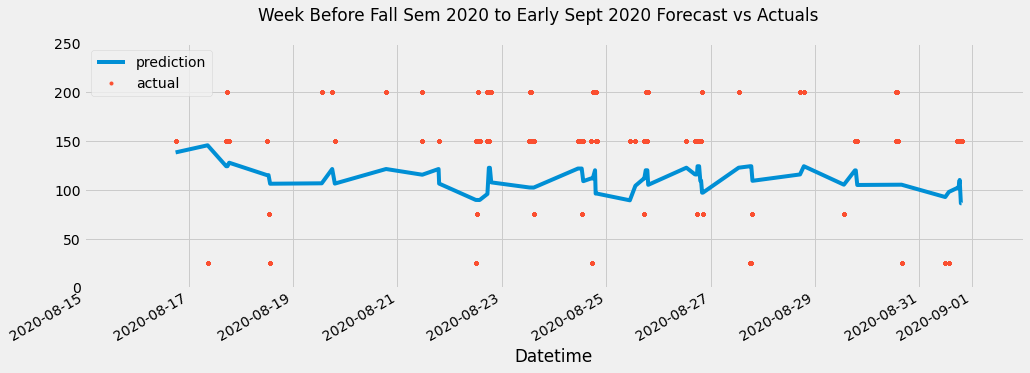

In [31]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_wiley[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-15-2020', upper='09-02-2020')
ax.legend(['prediction', 'actual'])
plot = plt.suptitle('Week Before Fall Sem 2020 to Early Sept 2020 Forecast vs Actuals')

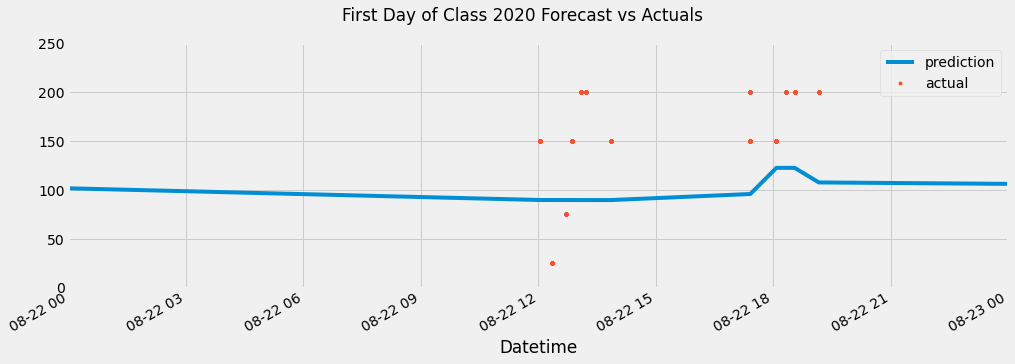

In [48]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_wiley[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-22-2020', upper='08-23-2020')
ax.legend(['prediction', 'actual'])
plot = plt.suptitle('First Day of Class 2020 Forecast vs Actuals')

In [33]:
#function to generate daily wait times by dining court

import datetime

def plot_generator(diningCourt, date):

    inputDate = date

    month,day,year = inputDate.split('/')

    isValidDate = True
    try :
        datetime.datetime(int(year),int(month),int(day))
    except ValueError :
        isValidDate = False

    if(not isValidDate) :
        return "Input date is not valid."
        

    if (diningCourt == "earhart"):
        df_all_custom = df_earhart
    elif (diningCourt == "ford"):
        df_all_custom = df_ford
    elif (diningCourt == "hillenbrand"):
        df_all_custom = df_hillenbrand
    elif (diningCourt == "wiley"):
        df_all_custom = df_wiley
    elif (diningCourt == "windsor"):
        df_all_custom = df_windsor
    elif (diningCourt == "all"):
        df_all_custom = df_all
    else:
        print("please input proper dining court!")
        return
    dateTimeObj = datetime.datetime.strptime(date, '%m/%d/%y')
    dateFinal = dateTimeObj.date()
    nextDay = dateFinal + datetime.timedelta(days=1)
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    _ = df_all_custom[['LineLengthPrediction']].plot(ax=ax,
                                                  style=['-','.'])
    #_ = df_all_custom[['LineLengthPrediction','LineLength']].plot(ax=ax,style=['-','.'])
    ax.set_ylim(0, 250)
    ax.set_xbound(lower=dateFinal, upper=nextDay)
    ax.set_yticks([0,50,100,150,200])
    ax.legend(['prediction', 'actual'])
    ax.set_yticklabels(['no line','in the lobby','filling the lobby','out the door', 'around the building'])
    plot = plt.suptitle(f'Forecasted queue length of {diningCourt.capitalize()} dining court for {dateFinal}')

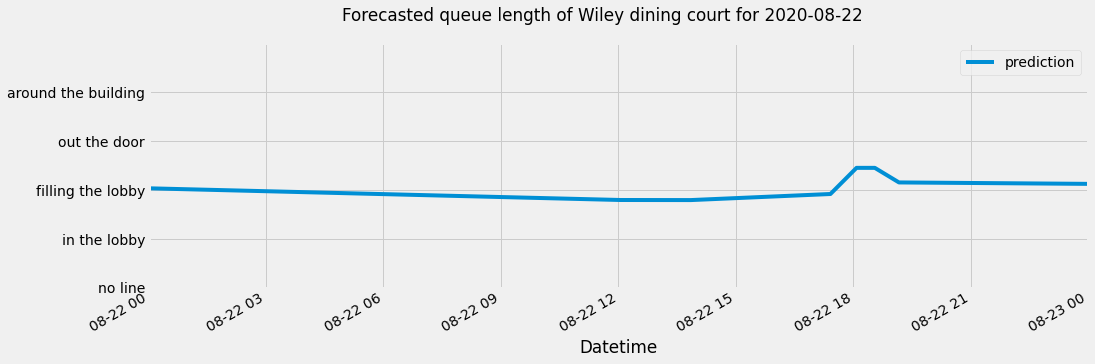

In [50]:
plot_generator("wiley", '08/22/20')

In [51]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_test.LineLength, predictions)

18.184432620155498

In [52]:
#import necessary libraries
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
sqrt(mean_squared_error(df_test.LineLength, predictions)) 

29.637437328956416

            LocationIdCode  MealTypeCode  MenuItemCode
Date                                                  
2020-08-31               1             0          1004
2020-08-31               1             0          1128
2020-08-31               1             0           858
2020-08-31               1             0           772
2020-08-31               1             0           882
...                    ...           ...           ...
2021-02-28               3             3           507
2021-02-28               3             3          1181
2021-02-28               3             3          1093
2021-02-28               3             3           556
2021-02-28               3             3           188

[52528 rows x 3 columns]
            hour  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
Date                                                                       
2020-08-31     0          0        3      8  2020        244          31   
2020-08-31     0          0    

<ipython-input-2-0d987608ff4c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


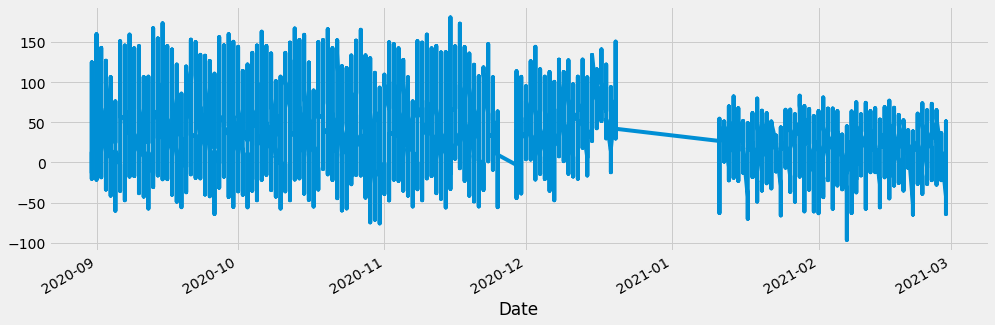

In [60]:
#put in your prediction dataset here:
#convert dataset to numerical categoricals
pSet = pd.read_csv('PredictionSet.csv', index_col=[0], parse_dates=[0])
pSet.LocationId = pd.Categorical(pSet.LocationId)
pSet['LocationIdCode'] = pSet.LocationId.cat.codes
del pSet['LocationId']

pSet.MealType = pd.Categorical(pSet.MealType)
pSet['MealTypeCode'] = pSet.MealType.cat.codes
del pSet['MealType']

pSet.MenuItem = pd.Categorical(pSet.MenuItem)
pSet['MenuItemCode'] = pSet.MenuItem.cat.codes
del pSet['MenuItem']

#create features for datetime
X_predict = create_features(pSet)

#this does the prediction!
pSet['LineLengthPrediction'] = xgb_model.predict(X_predict) * 1.25
_ = pSet['LineLengthPrediction'].plot(figsize=(15, 5))

#split prediction dataset by dining court
df_earhart = pSet.loc[pSet['LocationIdCode'] == 0]
df_ford = pSet.loc[pSet['LocationIdCode'] == 1]
df_hillenbrand = pSet.loc[pSet['LocationIdCode'] == 2]
df_wiley = pSet.loc[pSet['LocationIdCode'] == 3]
df_windsor = pSet.loc[pSet['LocationIdCode'] == 4]

In [86]:
#output preds to csv
mask = (df_earhart.index > '2020-08-15') & (df_earhart.index <= '2020-09-02')
output_earhart = df_earhart.loc[mask].LineLengthPrediction
output_earhart = output_earhart[~output_earhart.index.duplicated(keep='first')]

mask = (df_ford.index > '2020-08-15') & (df_ford.index <= '2020-09-02')
output_ford = df_ford.loc[mask].LineLengthPrediction
output_ford = output_ford[~output_ford.index.duplicated(keep='first')]

mask = (df_hillenbrand.index > '2020-08-15') & (df_hillenbrand.index <= '2020-09-02')
output_hillenbrand = df_hillenbrand.loc[mask].LineLengthPrediction
output_hillenbrand = output_hillenbrand[~output_hillenbrand.index.duplicated(keep='first')]

mask = (df_wiley.index > '2020-08-15') & (df_wiley.index <= '2020-09-02')
output_wiley = df_wiley.loc[mask].LineLengthPrediction
output_wiley = output_wiley[~output_wiley.index.duplicated(keep='first')]

mask = (df_windsor.index > '2020-08-15') & (df_windsor.index <= '2020-09-02')
output_windsor = df_windsor.loc[mask].LineLengthPrediction
output_windsor = output_windsor[~output_windsor.index.duplicated(keep='first')]

output_earhart.to_csv('OutputEarhart.csv', index=True)
output_ford.to_csv('OutputFord.csv', index=True)
output_hillenbrand.to_csv('OutputHillenbrand.csv', index=True)
output_wiley.to_csv('OutputWiley.csv', index=True)
output_windsor.to_csv('OutputWindsor.csv', index=True)

In [7]:
df_all

,LineLength,LocationIdCode,MealTypeCode,MenuItemCode,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,LineLengthPrediction
Datetime,,,,,,,,,,,,,,
2020-08-30 19:22:00,150,1,3,1404,2020-08-30 19:22:00,19,6,3,8,2020,243,30,35,124.688759
2020-08-30 19:22:00,150,1,3,1405,2020-08-30 19:22:00,19,6,3,8,2020,243,30,35,124.688759
2020-08-30 19:22:00,150,1,3,1408,2020-08-30 19:22:00,19,6,3,8,2020,243,30,35,124.688759
2020-08-30 19:22:00,150,1,3,2416,2020-08-30 19:22:00,19,6,3,8,2020,243,30,35,124.688759
2020-08-30 19:22:00,150,1,3,2154,2020-08-30 19:22:00,19,6,3,8,2020,243,30,35,124.688759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-02 17:58:00,200,2,1,2930,2017-11-02 17:58:00,17,3,4,11,2017,306,2,44,NaN
2017-11-02 17:58:00,200,2,1,2487,2017-11-02 17:58:00,17,3,4,11,2017,306,2,44,NaN
2017-11-02 17:58:00,200,2,1,711,2017-11-02 17:58:00,17,3,4,11,2017,306,2,44,NaN


In [8]:
df_earhart = df_all.loc[df_all['LocationIdCode'] == 0]
df_ford = df_all.loc[df_all['LocationIdCode'] == 1]
df_hillenbrand = df_all.loc[df_all['LocationIdCode'] == 2]
df_wiley = df_all.loc[df_all['LocationIdCode'] == 3]
df_windsor = df_all.loc[df_all['LocationIdCode'] == 4]

In [10]:
customHours = [7,8,9,10,11,12,13,14,15,17,18,19,20]

In [25]:
df_wiley.hour.unique()

array([18, 19, 10, 17, 13, 12, 11, 14, 15,  8, 20, 16,  9,  6,  7],
      dtype=int64)

In [15]:
earhart_output = pd.DataFrame(columns=['Day', 'Hour', 'LineLength'])

for day in df_earhart.dayofweek.unique():
    for hour in df_earhart.hour.unique():
        if hour in customHours:
            row = [day, hour, df_earhart.loc[df_earhart['hour'] == hour].LineLength.mean()]
            earhart_output.loc[len(earhart_output)] = row
earhart_output = earhart_output.astype(int)
earhart_output = earhart_output.sort_values(by = ['Day', 'Hour'], ascending = [True, True], na_position = 'first')
earhart_output.to_csv('OutputEarhart.csv', index=False)

In [16]:
ford_output = pd.DataFrame(columns=['Day', 'Hour', 'LineLength'])

for day in df_ford.dayofweek.unique():
    for hour in df_ford.hour.unique():
        if hour in customHours:
            row = [day, hour, df_ford.loc[df_ford['hour'] == hour].LineLength.mean()]
            ford_output.loc[len(ford_output)] = row
ford_output = ford_output.astype(int)
ford_output = ford_output.sort_values(by = ['Day', 'Hour'], ascending = [True, True], na_position = 'first')
ford_output.to_csv('OutputFord.csv', index=False)

In [17]:
hillenbrand_output = pd.DataFrame(columns=['Day', 'Hour', 'LineLength'])

for day in df_hillenbrand.dayofweek.unique():
    for hour in df_hillenbrand.hour.unique():
        if hour in customHours:
            row = [day, hour, df_hillenbrand.loc[df_hillenbrand['hour'] == hour].LineLength.mean()]
            hillenbrand_output.loc[len(hillenbrand_output)] = row
hillenbrand_output = hillenbrand_output.astype(int)
hillenbrand_output = hillenbrand_output.sort_values(by = ['Day', 'Hour'], ascending = [True, True], na_position = 'first')
hillenbrand_output.to_csv('OutputHillenbrand.csv', index=False)

In [18]:
wiley_output = pd.DataFrame(columns=['Day', 'Hour', 'LineLength'])

for day in df_wiley.dayofweek.unique():
    for hour in df_wiley.hour.unique():
        if hour in customHours:
            row = [day, hour, df_wiley.loc[df_wiley['hour'] == hour].LineLength.mean()]
            wiley_output.loc[len(wiley_output)] = row
wiley_output = wiley_output.astype(int)
wiley_output = wiley_output.sort_values(by = ['Day', 'Hour'], ascending = [True, True], na_position = 'first')
wiley_output.to_csv('OutputWiley.csv', index=False)

In [19]:
windsor_output = pd.DataFrame(columns=['Day', 'Hour', 'LineLength'])

for day in df_windsor.dayofweek.unique():
    for hour in df_windsor.hour.unique():
        if hour in customHours:
            row = [day, hour, df_windsor.loc[df_windsor['hour'] == hour].LineLength.mean()]
            windsor_output.loc[len(windsor_output)] = row
windsor_output = windsor_output.astype(int)
windsor_output = windsor_output.sort_values(by = ['Day', 'Hour'], ascending = [True, True], na_position = 'first')
windsor_output.to_csv('OutputWindsor.csv', index=False)